# Load merchant embeddings and transactions embeddings and see if we have any matches

In [1]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.6 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [3]:
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 75.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install fsspec==2023.6.0

Note: you may need to restart the kernel to use updated packages.


In [11]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [12]:
#!mv /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/ mm/


In [13]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/

INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [14]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install --upgrade sentence_transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
#%pip install --force-reinstall --no-deps fsspec==2023.6.0


### Download model

In [20]:
import boto3
import os

def download_s3_folder(bucket_name, s3_folder, local_path):
    """
    Download a folder (or "prefix") from S3 to the local filesystem.
    """
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        if 'Contents' in result:
            for key in result['Contents']:
                # Extract file name from S3 key
                key_name = key['Key']
                local_file_path = os.path.join(local_path, os.path.basename(key_name))
                
                # Check if the key represents a folder
                if key_name.endswith('/'):
                    # Create local directory if it doesn't exist
                    os.makedirs(local_file_path, exist_ok=True)
                    # Recursively download folder contents
                    download_s3_folder(bucket_name, key_name, local_file_path)
                else:
                    # Create directory if it doesn't exist
                    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                    # Download file
                    try:
                        s3.download_file(bucket_name, key_name, local_file_path)
                    except NotADirectoryError as e:
                        print(f"Skipping file '{key_name}' due to error: {e}")

# Example usage
bucket_name = 'cleo-data-science'
base_name_path = 'model9/checkpoint-7800'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}"
local_path = f"/home/sagemaker-user/models/{base_name_path}"

download_s3_folder(bucket_name, s3_folder, local_path)

bucket_name = 'cleo-data-science'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}/1_Pooling"
local_path = f"/home/sagemaker-user/models/{base_name_path}/1_Pooling"


download_s3_folder(bucket_name, s3_folder, local_path)


In [21]:
!ls /home/sagemaker-user/models/

model9


In [22]:
imodel = 9

### Load test data

In [23]:
%pip install awswrangler
import awswrangler as wr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 21.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

### Load embeddings

In [12]:
s3_path_tx_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_trans_2024-05-22_2024-05-22.parquet"
# --- no merchant
s3_path_tx_embeddings ="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_trans_2024-05-22_2024-05-22.parquet"
# --- with duplicates

In [15]:
s3_path_merchant_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/merchant_embeddings_cons_2024-05-15_2024-05-18_1.parquet"

In [38]:
df_tx_embeddings = wr.s3.read_parquet(path=s3_path_tx_embeddings)


In [39]:
df_tx_embeddings.head()

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name
0,"[-0.09991075098514557, -0.20930267870426178, 0...",9870525860,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,None
1,"[-0.41577568650245667, 0.606635570526123, 0.02...",9870662455,Purchase #10 Galesburg #6 Galesburg US,None
2,"[0.07951699942350388, -0.04787381365895271, 0....",9870920485,DONATION ROMIELL,None
3,"[-0.08092399686574936, 0.678030252456665, 1.09...",9871069670,SP CLICKS TECHNOLOGY,None
4,"[0.09376141428947449, 0.0005073878564871848, -...",9871165272,PELHAM BAY DELI GROC,None


In [40]:
df_merchant_embeddings =wr.s3.read_parquet(path=s3_path_merchant_embeddings)


In [41]:
df_tx_embeddings.shape

(91613, 4)

In [42]:
tx_embeddings = df_tx_embeddings.loc[0:100,'description_combined_processed_embedding'].tolist()

In [43]:
tx_embeddings

[array([-9.99107510e-02, -2.09302679e-01,  5.02122760e-01, -8.41545537e-02,
         2.93202519e-01, -5.80790676e-02,  1.77702438e-02, -2.32133389e-01,
        -4.05280620e-01, -2.04935893e-01, -5.11179626e-01, -4.74578887e-01,
        -1.55357778e-01,  1.12233728e-01,  3.23093981e-02,  7.27779448e-01,
         3.17907870e-01,  1.23267010e-01,  1.01575160e+00,  8.57311189e-02,
         3.89451802e-01,  1.79570541e-01, -5.19187510e-01,  5.46734095e-01,
         1.38099506e-01, -1.09205633e-01, -2.17978936e-02, -5.43782786e-02,
        -2.05895990e-01,  8.99535790e-02, -3.32945436e-02,  7.13115782e-02,
         5.35133146e-02, -3.02562177e-01,  2.34617636e-01, -8.44974965e-02,
         2.54254967e-01, -6.17579669e-02,  6.49689376e-01,  2.49169320e-01,
         8.05153996e-02, -5.60567260e-01, -1.49224177e-01,  2.72202492e-03,
         2.99958378e-01,  2.39688143e-01, -1.41497836e-01,  7.42903709e-01,
         5.38335562e-01, -9.22480673e-02, -3.87496680e-01, -1.00946814e-01,
         3.2

In [44]:
from sentence_transformers import SentenceTransformer, models
# from sentence_transformers import SentenceTransformer, InputExample
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset, DataLoader
# from sentence_transformers.losses import CoSENTLoss
# from datasets import Dataset
# from sentence_transformers.training_args import SentenceTransformerTrainingArguments
# from sentence_transformers.training_args import BatchSamplers
# from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
# from sentence_transformers import SentenceTransformerTrainer

In [45]:
embeddings_merchants = df_merchant_embeddings['original_merchant_name_combined_embedding'].tolist()

In [46]:
imodel = 9
istep = 5000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [47]:
import torch

In [48]:
list_unique_merchants = df_merchant_embeddings['original_merchant_name_combined'].tolist()


In [49]:
def do_predictions(model, df, batch_size_preds, embeddings_merchants, df_tx_embeddings):
    batch_size = batch_size_preds
    df['pred_merchant']=""
    df['pred_prob']=0.0
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = df.loc[istart:iend-1,'description_combined_processed_embedding'].tolist()
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [50]:
batch_size_preds = 5000
df_tx_embeddings = do_predictions(model, df_tx_embeddings, batch_size_preds, embeddings_merchants, df_tx_embeddings)

0 5000
torch.Size([5000, 86094])
5000 10000
torch.Size([5000, 86094])
10000 15000
torch.Size([5000, 86094])
15000 20000
torch.Size([5000, 86094])
20000 25000
torch.Size([5000, 86094])
25000 30000
torch.Size([5000, 86094])
30000 35000
torch.Size([5000, 86094])
35000 40000
torch.Size([5000, 86094])
40000 45000
torch.Size([5000, 86094])
45000 50000
torch.Size([5000, 86094])
50000 55000
torch.Size([5000, 86094])
55000 60000
torch.Size([5000, 86094])
60000 65000
torch.Size([5000, 86094])
65000 70000
torch.Size([5000, 86094])
70000 75000
torch.Size([5000, 86094])
75000 80000
torch.Size([5000, 86094])
80000 85000
torch.Size([5000, 86094])
85000 90000
torch.Size([5000, 86094])
90000 91613
torch.Size([1613, 86094])


In [51]:
#write predictions to file 
base_name = '/'.join(s3_path_tx_embeddings.split('/')[:-1])
s3_path_out =  f"{base_name}/predictions_{s3_path_tx_embeddings.split('/')[-1]}"
wr.s3.to_parquet(
        df=df_tx_embeddings,
        path=s3_path_out,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out}")

Finsihed writing file s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet


In [1]:
%pip install awswrangler
import awswrangler as wr

Note: you may need to restart the kernel to use updated packages.


In [4]:
s3_embeddings_out= "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"

In [5]:
df_tx_embeddings = wr.s3.read_parquet(s3_embeddings_out)

<Axes: >

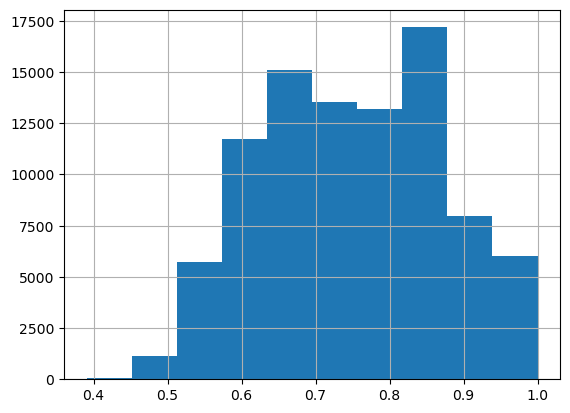

In [6]:
df_predictions = df_tx_embeddings.drop('description_combined_processed_embedding',axis=1)
df_predictions['pred_prob'].hist()

In [7]:
df_predictions.sort_values(by='pred_prob', ascending=False, inplace=True)
df_predictions

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob
29914,9880254091,Walgreens,None,Walgreens,1.000000
2974,9878633108,Arby''s,None,Arby''s,1.000000
88397,9880650239,Wesco,None,Wesco,1.000000
26504,9877615384,Walgreens,None,Walgreens,1.000000
30006,9872225649,Walgreens,None,Walgreens,1.000000
...,...,...,...,...,...
57111,9886135252,POS Debit - Visa Check Card - SW- STEEPLECHASE...,None,Westchase Food Store,0.417283
77872,9884786402,PEGASUSPARK_1 DALLAS TX 05/20,None,Swingby,0.417148
85945,9889345314,PEGASUSPARK_1 DALLAS TX 05/20,None,Swingby,0.417148
35809,9884909693,ZELLE TO FASHOLA TONYA ON 05/22 REF #RP0S8QGD5...,None,Just Us Grocery,0.416788


In [18]:
df_predictions.sort_values(by='pred_prob', ascending=True, inplace=True)
df_predictions_conf = df_predictions[df_predictions['pred_prob']>0.8]
df_predictions_conf.reset_index(drop=True, inplace=True)
df_predictions_conf

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob
0,9884208339,ANTILLANA MEAT 05/22 # MOBILE PURCHASE 123 W K...,None,Antillana Fresh Meat Ma Bronx,0.800001
1,9885830829,CHECKCARD PAYPAL *XON4LMUSIC XON CA,None,Paypal Pay in 4,0.800009
2,9885830834,CHECKCARD PAYPAL *XON4LMUSIC XON CA,None,Paypal Pay in 4,0.800009
3,9927753906,DDA PURCHASE AP BJS FUEL 650 MEMOR CHICOPEE * MA,None,Bjs Fuel,0.800022
4,9887483070,POS Debit - Visa Check Card - PAPA JOHNS FELIC...,None,Papa V S,0.800031
...,...,...,...,...,...
34934,9879396187,Walgreens,None,Walgreens,1.000000
34935,9911738734,Wesco,None,Wesco,1.000000
34936,9877615383,Walgreens,None,Walgreens,1.000000
34937,9876960950,Arby''s,None,Arby''s,1.000000


In [20]:
df_predictions_conf['pred_merchant'].value_counts().to_frame()[0:50]

,count
pred_merchant,
Betfair,1551
Uber,1265
Draftkings,1166
McDonald''s,544
Apple Card,500
Lyft,467
FanDuel,382
Amazon,361
Apple,355


In [19]:

#write to csv file 
wr.s3.to_csv(
    df=df_predictions_conf,
    path="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/csv_predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.csv"
)

{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/csv_predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.csv'],
 'partitions_values': {}}

In [6]:
#load embeddings
df_tx_embeddings = wr.s3.read_parquet(path=s3_embeddings_out)
df_tx_embeddings.shape

(1000000, 6)

In [15]:
list_unique_merchants = df_merchant_embeddings['original_merchant_name_combined'].tolist()


In [ ]:
df_merchant_embeddings.head()

In [12]:
df_tx_embeddings.head(2)

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,count
0,"[-0.0872960239648819, 0.5050700902938843, -0.1...",9878632619,Taco Bell,Taco Bell,Taco Bell,1.0,Taco Bell,78960
1,"[-0.08729638159275055, 0.5050702691078186, -0....",9879884711,Taco Bell,Taco Bell,Taco Bell,1.0,Taco Bell,78960


In [16]:
# How many of the test set merchants are in the original training dataset

print(df_tx_embeddings['merchant_name'].nunique())
max_possible_matches = df_tx_embeddings[df_tx_embeddings['merchant_name'].isin(list_unique_merchants)]
print(max_possible_matches['merchant_name'].nunique())
n_max_possible_matches = max_possible_matches.shape[0]

28838
28838


In [17]:
th = 0.9

df_filtered = df_tx_embeddings[df_tx_embeddings['pred_prob']>th]
true_positives = df_filtered[df_filtered['pred_merchant'] == df_filtered['merchant_name']].shape[0]
false_positives = df_filtered[df_filtered['pred_merchant'] != df_filtered['merchant_name']].shape[0]
precision = true_positives/(true_positives+false_positives)
#recall = true_positives/true_positives + false_negatives
max_possible_matches = df_filtered[df_filtered['merchant_name'].isin(list_unique_merchants)].shape[0]
recall = true_positives/n_max_possible_matches
print(f"Precision {precision} Recall {recall}")

Precision 0.7546637598844936 Recall 0.2644532009140682


In [18]:
df_tx_embeddings['is_right'] = df_tx_embeddings['merchant_name'] == df_tx_embeddings['pred_merchant']


In [20]:
df_tx_embeddings.head()

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,count,is_right
0,"[-0.0872960239648819, 0.5050700902938843, -0.1...",9878632619,Taco Bell,Taco Bell,Taco Bell,1.000000,Taco Bell,78960,True
1,"[-0.08729638159275055, 0.5050702691078186, -0....",9879884711,Taco Bell,Taco Bell,Taco Bell,1.000000,Taco Bell,78960,True
2,"[0.15031003952026367, 0.07755867391824722, -0....",9939649901,TACO BELL 05-20 SUWANEE GA DEBIT CARD PURCHASE,Taco Bell,Taco Bell,0.873835,Taco Bell,78960,True
3,"[0.131413996219635, -0.04788760840892792, -0.2...",9879793146,TACO BELL OWENSBORO KY,Taco Bell,Taco Bell,0.902106,Taco Bell,78960,True
4,"[0.2902907133102417, -0.04023505002260208, -0....",9891449191,Debit Purchase -visa Taco Bell tacoma Wa 05/20...,Taco Bell,Taco Bell,0.855357,Taco Bell,78960,True


In [100]:
df_tx_embeddings[~df_tx_embeddings['is_right']]

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,is_right,original_merchant_name_combined,count
17,"[-0.4217905104160309, 0.7376061081886292, -0.0...",9878959595,Doordash,Taco Bell,Doordash,1.000000,False,Taco Bell,78960
24,"[0.5265252590179443, 0.757443904876709, 0.0676...",9885132586,MOBILE PURCHASE TB/PH # MONROVIA CA,Taco Bell,Tbl,0.612698,False,Taco Bell,78960
26,"[-0.4217904508113861, 0.7376060485839844, -0.0...",9876823345,Doordash,Taco Bell,DoorDash,1.000000,False,Taco Bell,78960
27,"[-0.4217905104160309, 0.7376061081886292, -0.0...",9878519616,Doordash,Taco Bell,Doordash,1.000000,False,Taco Bell,78960
48,"[-0.4217905104160309, 0.7376061081886292, -0.0...",9878633829,Doordash,Taco Bell,Doordash,1.000000,False,Taco Bell,78960
...,...,...,...,...,...,...,...,...,...
895320,"[-1.2132959365844727, 1.1464606523513794, 0.47...",9920891955,Rfs*Eaton Mi,Rfs,D Eaton,0.663751,False,Rfs,2
895322,"[0.7708784341812134, 0.9186383485794067, 0.348...",9880267028,El Rancho Bar & Grill D,El Rancho Bar,El Rancho Mexican Grill,0.845901,False,El Rancho Bar,4
895328,"[-0.32814323902130127, -0.5538128614425659, -0...",9884098698,STOP 1 LEXINGTON DELI NEW YORK NY 05/21,Stop 1 Inc,1 Stop Plaza Inc,0.730666,False,Stop 1 Inc,14
895330,"[-0.4217905104160309, 0.7376061081886292, -0.0...",9878434550,Doordash,Marblesla,Doordash,1.000000,False,Marblesla,8


In [21]:
df_tx_embeddings['original_merchant_name_combined']

0                      Taco Bell
1                      Taco Bell
2                      Taco Bell
3                      Taco Bell
4                      Taco Bell
                   ...          
895333            Pza Conc C Clt
895334    St Bernard Parish Util
895335                  Heritage
895336                 Homewater
895337                    Nissan
Name: original_merchant_name_combined, Length: 895338, dtype: string

In [23]:
df_tx_embeddings['true_vs_pred'] = df_tx_embeddings['original_merchant_name_combined']+" :: "+df_tx_embeddings['pred_merchant']

In [33]:
df_right = df_tx_embeddings[df_tx_embeddings['is_right']]
df_wrong = df_tx_embeddings[~df_tx_embeddings['is_right']]

In [30]:
df_pairs_correct = df_right.groupby('true_vs_pred')['transaction_id'].agg('count').to_frame()
df_pairs_correct.reset_index(drop=False, inplace=True)
df_pairs_correct.rename(columns={'transaction_id':'num_transactions'}, inplace=True)
df_pairs_correct.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_correct

,true_vs_pred,num_transactions
14010,McDonald''s :: McDonald''s,28685
982,Amazon :: Amazon,22593
23247,Uber :: Uber,19461
19653,Shell :: Shell,14062
4455,Circle K :: Circle K,13200
...,...,...
11779,Kanz Deli Grocery Inc Brooklyn :: Kanz Deli Gr...,1
11780,Kao Inc :: Kao Inc,1
11782,Karam Convenience Corp :: Karam Convenience Corp,1
11783,Karens :: Karens,1


In [35]:
df_pairs_incorrect = df_wrong.groupby('true_vs_pred')['transaction_id'].agg('count').to_frame()
df_pairs_incorrect.reset_index(drop=False, inplace=True)
df_pairs_incorrect.rename(columns={'transaction_id':'num_transactions'}, inplace=True)
df_pairs_incorrect.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_incorrect.reset_index(drop=True, inplace=True)
df_pairs_incorrect

,true_vs_pred,num_transactions
0,Apple :: Apple Card,23087
1,Walmart :: Walmart+,18395
2,Cleo :: Cleo AI,18020
3,Fan Duel Sportsbook :: FanDuel,11464
4,7 Eleven :: 7-Eleven,10778
...,...,...
21129,Gulf New Gretna :: Gulf,1
21130,Gulf Oil :: Atm,1
21131,Gulf Oil :: Gulf N Main Pet,1
21132,Gulf Oil :: Gulfbank Road,1


In [57]:
df_pairs_incorrect = df_wrong.groupby('true_vs_pred').agg(num_transactions=('transaction_id','count'), avg_prob=('pred_prob','mean'))
df_pairs_incorrect.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_incorrect.reset_index(drop=False, inplace=True)
df_pairs_incorrect_filtered = df_pairs_incorrect[(df_pairs_incorrect['num_transactions']>4) & (df_pairs_incorrect['avg_prob']>0.7)]
df_pairs_incorrect_filtered[0:20]

,true_vs_pred,num_transactions,avg_prob
0,Apple :: Apple Card,23087,0.852366
1,Walmart :: Walmart+,18395,0.820802
2,Cleo :: Cleo AI,18020,0.915326
3,Fan Duel Sportsbook :: FanDuel,11464,0.914919
4,7 Eleven :: 7-Eleven,10778,0.907264
5,Genie :: Credit Genie,5302,0.834486
6,365 Markets :: 3 C Market 5640,5272,0.834902
7,QuikTrip :: Qlt,2881,0.785879
8,BetMGM.com :: BetMGM,2860,0.876673
9,Dunkin'' Donuts :: Dunkin'',2797,0.851925


In [58]:
wr.s3.to_csv(
    df=df_pairs_incorrect_filtered[df_pairs_incorrect_filtered['avg_prob']>0.8],
    path=incorrect_test_preds_csv,
)


{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/incorrect_predictions_with_merchant_embeddings_trans_2024-05-22_2024-05-22.csv'],
 'partitions_values': {}}

In [ ]:
df_pairs_incorrect

In [38]:
'Cleo AI' in  list_unique_merchants

True

In [ ]:
df_tx_embeddings['pred_merchant'].

# some predicted names like Cleo AI  don't exist, they are duplicates

In [37]:
df_pairs_incorrect[0:100]

,true_vs_pred,num_transactions
0,Apple :: Apple Card,23087
1,Walmart :: Walmart+,18395
2,Cleo :: Cleo AI,18020
3,Fan Duel Sportsbook :: FanDuel,11464
4,7 Eleven :: 7-Eleven,10778
...,...,...
95,In N Out Burger :: In-n-out Redding,354
96,Fan Duel Sportsbook :: Fspc,353
97,Hard Rock Bet :: Hard Rock Bet Appl,347
98,Dashpass :: Dashpa Www.doordash.,345


## Finished 

In [ ]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14"
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"

# df_data_raw= wr.s3.read_parquet(path=s3_path)
# df_data_processed.shape

s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/trans_2024-05-22_2024-05-22"
df_data_raw= wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

In [ ]:
keep_cols =['transaction_id','category_primary_plaid','merchant_name','original_description_plaid','description','amount']

In [ ]:
df_data_raw = df_data_raw[keep_cols]

In [ ]:
df_data_raw = df_data_raw[~df_data_raw['category_primary_plaid'].isin(['TRANSFER_OUT','TRANSFER_IN','LOAN_PAYMENTS','INCOME','BANK_FEES'])]
df_data_raw['len_description'] = df_data_raw['original_description_plaid'].apply(lambda x:len(x))
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace('None',None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace('',None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace(' ',None)
df_data_raw = df_data_raw.map(lambda x: None if pd.isna(x) else x)
pattern_transfer = r"(Cash\sApp\sTransfer\s[\w\s;]*)"
pattern_cash = r"(Cash\sApp)\s[\w\s;]*"
pattern_apple_cash_transfer = r"(Apple\sCash\sTransfer\s[\w\s;]*)"

df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_transfer, r"Cash App Transfer", str(x)) if x != None  else None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_cash, r"Cash App", str(x)) if x != None  else None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_apple_cash_transfer, r"Apple Cash", str(x)) if x != None  else None)



In [ ]:
df_data_raw['description_combined'] = df_data_raw['original_description_plaid'].combine_first(df_data_raw['description'])
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined'].apply(lambda x: re.sub('\\\\+','\\\\',x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'(.)\1{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
df_data_raw_no_merchant = df_data_raw[df_data_raw['merchant_name'].isnull()]
df_data_raw_with_merchant = df_data_raw[~df_data_raw['merchant_name'].isnull()]

In [ ]:
print(df_data_raw_no_merchant.shape[0])
print(df_data_raw_with_merchant.shape[0])

In [ ]:
df_data_raw_no_merchant = df_data_raw_no_merchant[df_data_raw_no_merchant['len_description'] >= 3]
df_data_raw_with_merchant = df_data_raw_with_merchant[df_data_raw_with_merchant['len_description'] >= 3]
print(df_data_raw_no_merchant.shape[0])
print(df_data_raw_with_merchant.shape[0])

In [ ]:
#sample to make faset
df_data_raw_with_merchant = df_data_raw_with_merchant.sample(1000000, random_state=1)

In [ ]:
df_data_raw_with_merchant['category_primary_plaid'].value_counts()

In [ ]:
df_data_raw_no_merchant['category_primary_plaid'].value_counts()

In [ ]:
df_data_raw_with_merchant.head(2)

In [ ]:
def positive_avg(series):
    return series.dropna()[series > 0].mean()
def negative_avg(series):
    return series.dropna()[series < 0].mean()

df_counts_tx = df_data_raw_with_merchant.groupby('merchant_name').agg(distinct_transactions =  ('transaction_id','nunique'),\
    avg_positive_amount = ('amount', positive_avg), avg_negative_amount =  ('amount', negative_avg))

In [ ]:
df_counts_tx.sort_values(by='distinct_transactions', ascending=False, inplace=True)
df_counts_tx = df_counts_tx.fillna(0)
df_counts_tx

In [ ]:
df_counts_tx[df_counts_tx['distinct_transactions']==1].shape

In [ ]:
try:
    del df_data_raw
except:
    pass

In [ ]:
df_data_raw_with_merchant = pd.merge(df_data_raw_with_merchant, df_counts_tx, left_on='merchant_name', right_on='merchant_name', how='left')

In [ ]:
df_data_raw_with_merchant.head()

# Load embedding model

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [ ]:
imodel = 9
istep = 5000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [ ]:
import sentence_transformers
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [ ]:
text_column =  "description_combined_processed"

In [ ]:
print(df_data_raw_with_merchant['merchant_name'].nunique())

In [ ]:
df_data_raw_with_merchant_cnt.head()

In [ ]:
import torch

In [ ]:
def get_tx_description_embeddings(model, df, text_column, batch_size_preds):
    batch_size = batch_size_preds
    all_embeddings = empty_array = np.empty((0, 768))

    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            all_embeddings = np.concatenate((all_embeddings, tx_embeddings), axis=0)
            #df.loc[istart:iend-1,'tx_embedding'] =  tx_embeddings
    
    # Convert the numpy array into a list of arrays (or lists)
    embeddings_as_lists = [all_embeddings[i, :] for i in range(all_embeddings.shape[0])]

    # Create a DataFrame and assign the list of arrays to a single column
    df_embeddings = pd.DataFrame({text_column+'_embedding': embeddings_as_lists})
    df_embeddings['transaction_id'] = df['transaction_id']
    df_embeddings[text_column] = df[text_column]
    df_embeddings['merchant_name'] = ""
    try:
        df_embeddings['merchant_name'] = df['merchant_name']
    except:
        pass
    return df_embeddings    

In [ ]:
batch_size_preds = 5000
all_embeddings_1 = get_tx_description_embeddings(model, df_data_raw_with_merchant, text_column, batch_size_preds)

In [ ]:
#save embeddings in output file 
print(s3_path.split('/raw/')[1])

#s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/trans_2024-05-22_2024-05-22"


In [ ]:
s3_path_out_embeddings = f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model{imodel}/checkpoint-{istep}/with_merchant_embeddings_{s3_path.split('/raw/')[1]}.parquet"
s3_path_out_data_with_merchant = f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model{imodel}/checkpoint-{istep}/with_merchant_{s3_path.split('/raw/')[1]}.parquet"
print(s3_path_out_embeddings)
print(s3_path_out_data_with_merchant)

In [ ]:
wr.s3.to_parquet(
        df=df_data_raw_with_merchant,
        path=s3_path_out_data_with_merchant,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out_data_with_merchant}")


In [ ]:
wr.s3.to_parquet(
        df=all_embeddings_1,
        path=s3_path_out_embeddings,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out_embeddings}")

In [ ]:
all_embeddings_1

# FINISH

In [ ]:
# load file to make sure everything is working
import awswrangler as wr
path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
df_embeddings_load= wr.s3.read_parquet(path=path_out)
print(df_embeddings_load.shape)
df_embeddings_load.head()

In [ ]:

# Convert the numpy array into a list of arrays (or lists)
embeddings_as_lists = [all_embeddings_1[i, :] for i in range(all_embeddings_1.shape[0])]

# Create a DataFrame and assign the list of arrays to a single column
df_embeddings = pd.DataFrame({text_column+'_embedding': embeddings_as_lists})
df_embeddings

In [ ]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [ ]:
# From the test data, 
# Check how many get assigned to the right merchant
# precision and recall

In [ ]:
# From the test data
# See how many un

In [ ]:
df_data_raw_no_merchant.shape

In [ ]:
df_data_raw_no_merchant.head()

### Load model

In [ ]:
df_data_raw_no_merchant[df_data_raw_no_merchant['category_primary_plaid'] == 'GOVERNMENT_AND_NON_PROFIT']

In [ ]:
df_data_raw_no_merchant.head()

In [ ]:
df2['merchant_name'].isnull()

In [ ]:
df_data_raw_no_merchant.loc[7,'merchant_name']

In [ ]:
import pandas as pd

In [ ]:
df2 = df_data_raw_no_merchant.map(lambda x: None if pd.isna(x) else x)

In [ ]:

pattern_transfer = r"(Cash\sApp\sTransfer\s[\w\s;]*)"
pattern_cash = r"(Cash\sApp)\s[\w\s;]*"
pattern_apple_cash_transfer = r"(Apple\sCash\sTransfer\s[\w\s;]*)"

df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_transfer, r"Cash App Transfer", str(x)) if x != None  else None)


In [ ]:
df2[df2['merchant_name'].isnull()]

In [ ]:
df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_cash, r"Cash App", str(x)) if x != None  else None)
df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_apple_cash_transfer, r"Apple Cash", str(x)) if x != None  else None)

In [ ]:
df2[df2['merchant_name'].isnull()].shape

In [ ]:
df_data_raw_no_merchant.loc[7,'merchant_name']

In [ ]:
df_data_raw_no_merchant = df_data_raw[df_data_raw['merchant_name'].isnull()]
df_data_raw_no_merchant.shape

In [ ]:
df_data_raw_no_merchant.reset_index(drop=True, inplace=True)
df_data_raw_no_merchant.shape

In [ ]:
df_data_raw.head()

In [ ]:
# df_data_processed[df_data_processed['true_merchant_name_combined'] == 'Cleo Re']

In [ ]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/ac45bd41a9274be39fe18728158c8beb.snappy.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"


df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

In [ ]:
import pandas as pd

In [ ]:
import re
pattern = r"Cash\sApp\s(?!Transfer)[\w\s]+"
result = re.sub(pattern, "Cash App", 'Cash App Transfer')
result
df_data_raw['original_merchant_name_combined'] = df_data_raw['original_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )
df_data_raw['true_merchant_name_combined'] = df_data_raw['true_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x))
df_data_raw['merchant_name_combined'] = df_data_raw['merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )

In [ ]:
d1 = df_data_raw[df_data_raw['original_merchant_name_combined'] == 'Cash App'][:]
d2 = df_data_raw[df_data_raw['original_merchant_name_combined'] != 'Cash App'][:]
df_data_raw = pd.concat([d1.sample(50000, random_state = 1), d2], axis=0)
df_data_raw = df_data_raw.sample(3000000, random_state =1)

In [ ]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.05, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_test.shape[0], df_val.shape[0])

In [ ]:
df_train.head()

In [ ]:
df_test[df_test['original_merchant_name_combined'] == 'Cash App']

In [ ]:
df_merchants_counts = df_train['original_merchant_name_combined'].value_counts().to_frame()
df_merchants_counts.reset_index(drop=False, inplace=True)
top_merchants  = df_merchants_counts[0:2000]['original_merchant_name_combined'].to_list()
top_merchants

### First case when test set only has top merchants

In [ ]:
df_test_all = df_test.copy(deep=True)
df_test = df_test_all[df_test_all['original_merchant_name_combined'].isin(top_merchants)][:]
df_test.reset_index(drop=True, inplace=True)
df_test

In [ ]:
print(df_test['original_merchant_name_combined'].nunique())
print(df_test['true_merchant_name_combined'].nunique())
#print(df_test['merchant_name_combined'].nunique())

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [ ]:
df_test.head()

In [ ]:
df_test.reset_index(drop=True, inplace=True)
ds_test = Dataset.from_pandas(df_test[['true_label','description_combined_processed','merchant_name_combined']])
ds_test = ds_test.rename_columns({"true_label": "score","description_combined_processed":"sentence1", "merchant_name_combined":"sentence2"})

In [ ]:
imodel = 9
istep = 2000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [ ]:
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [ ]:
text_column =  "description_combined_processed"

In [ ]:
# dev_evaluator = EmbeddingSimilarityEvaluator(
#     sentences1=df_test[text_column],
#     sentences2=df_test["true_merchant_name_combined"],
#     scores=df_test["true_label"],
#     main_similarity=SimilarityFunction.COSINE,
#     name="sts-dev",
# )

In [ ]:
df_test['true_merchant_name_combined'].nunique()

In [ ]:
list_unique_merchants = df_train['original_merchant_name_combined'].unique()
print(f"Number of unique merchant {len(list_unique_merchants)}")
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

In [ ]:
import torch

In [ ]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [ ]:
# df_test = df_test[df_test['true_label']==1][:]
# df_test.reset_index(drop=True, inplace=True)

In [ ]:
df_test.shape

In [ ]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['original_merchant_name_combined'].nunique())

In [ ]:
# df_test = do_predictions(model, df_test,text_column, 10000,embeddings_merchants)

In [ ]:
df_test.head()

In [ ]:
def get_prec_recall(df, th):

    df_filtered = df[df['pred_prob']>=th]
    n_filt = df_filtered.shape[0]
    true_positives = df_filtered[(df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']) | (df_filtered['original_merchant_name_combined'] == df_filtered['pred_merchant']) ].shape[0]
    false_positives = df_filtered[(df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']) & (df_filtered['original_merchant_name_combined'] != df_filtered['pred_merchant']) ].shape[0]

    # true_positives = df_filtered[df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']].shape[0]
    # false_positives = df_filtered[df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']].shape[0]
    #precision = tp /tp + fp
    if n_filt >= 1:
        precision = true_positives/n_filt
    else:
        precision = 0.0
    #recall = tp /tp + fn
    recall = true_positives/df.shape[0]
    return precision, recall


In [ ]:
batch_size_pred = 5000
imodel = 9

# Compare two different epochs

In [ ]:

def get_df_with_preds(df, imodel, istep, batch_size_pred):
    model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
    model = SentenceTransformer(model_name)
    df['pred_prob'] = 0.0
    df_['pred_merchant']=""
    df = do_predictions(model, df,text_column, batch_size_pred,embeddings_merchants)
    precision, recall = get_prec_recall(df, th)
    print(istep, precision, recall)
    return df, precision, recall 

In [ ]:
df_test.shape[0]

In [ ]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['original_merchant_name_combined'].nunique())



In [ ]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1600
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 2000
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

In [ ]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1400
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 1600
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

In [ ]:
imodel = 7
istep1 = 800
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 900
df_test2, precision2, recall2 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep2,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

In [ ]:
prec_vec, recall_vec = [], []
th = 0.9

istep in range(100, 300, 400):
# istep_range =  [200,2000,2200]
for istep in istep_range:
   
   model_name = f"/home/sagemaker-user/models/model{imodel}-{istep}"
   model = SentenceTransformer(model_name)
   df_test['pred_prob'] = 0.0
   df_test['pred_merchant']=""
   df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)
   precision, recall = get_prec_recall(df_test, th)
   print(istep, precision, recall)
   prec_vec.append(precision)
   recall_vec.append(recall)
plt.plot(istep_range,prec_vec,'.-')
plt.plot(istep_range,recall_vec,'.-')

In [ ]:
#df_test1, precision1, recall1 = get_df_with_preds(df_test, imodel, 600, batch_size_pred)
#df_test2 has the lastest epoch

In [ ]:
df_test2.head(2)

### One epoch score distribution

In [ ]:
df_test.shape[0]

In [ ]:
#df_small = df_test.sample(100000).reset_index(drop=True)

In [ ]:
# one epoch

imodel = 9
istep1 = 2000
th = 0.75
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
plt.legend([istep1])

In [ ]:
#   original_merchant_name_combined is the real one ,
# merchant_name_cobined is the modified duplicate with coutnerprty 
# df_trans['original_merchant_name_combined'] = df_trans['merchant_name_combined']
# for duplicates , if counterparty_name != merchatn, then merchant_name_combined = counterparty_name
# merchant_name_combined : for duplicates, take

In [ ]:
print(precision1, recall1)

# Lets look at the duplicates only

In [ ]:
df_true_duplicates = df_test1[df_test1['is_duplicate']==1]
df_true_duplicates.reset_index(drop=True, inplace=True)
df_true_duplicates

In [ ]:
df_confident_duplicates = df_test1[(df_test1['pred_prob']>0.7) & (df_test['is_duplicate']==1)][['transaction_id','description_combined_processed','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','pred_prob','is_duplicate']]
# ,'merchant_name_combined','true_label'
df_confident_duplicates

Basically , we want to know what percentage got deduplicated 

- pred_merchant == original_merchant_name_combined

And what percentage got mapped to the original merchant 

- pred_merchant == true_merchant_name_combined


And how many times it got mapped to something else





In [ ]:
#number of rows that got correctly mapped to the original merchant name
n_correct_duplicates_rows_detected_df = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['original_merchant_name_combined']]

n_correct_duplicates_rows_detected = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['original_merchant_name_combined']].shape[0]
n_correct_duplicates_rows_detected

In [ ]:
#number of rows that got correctly mapped to the duplicate name
n_correct_rows_mapped_df = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['true_merchant_name_combined']]

n_correct_rows_mapped = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['true_merchant_name_combined']].shape[0]
n_correct_rows_mapped

In [ ]:
#numebr of rows that were not correctly mapped to either the original or duplicate name
n_incorrect_rows_df = df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])]


n_incorrect_rows= df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])].shape[0]
n_incorrect_rows

In [ ]:
n_incorrect_rows_df= df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])]

n_incorrect_rows_df[0:30]

### Find the pairs of merchants that are beind considered as non-duplicate, duplicate

In [ ]:
n_correct_duplicate_pairs = n_correct_duplicates_rows_detected_df.drop_duplicates(subset=['pred_merchant','true_merchant_name_combined'])
n_correct_duplicate_pairs

In [ ]:
n_correct_nonduplicate_pairs = n_correct_rows_mapped_df.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_correct_nonduplicate_pairs

In [ ]:
n_incorrect_duplicate_pairs = n_incorrect_rows_df.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_incorrect_duplicate_pairs[0:30]

In [ ]:
n_true_duplicates = df_true_duplicates.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_true_duplicates

In [ ]:
df_true_duplicate_pairs = df_true_duplicates.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
df_true_duplicate_pairs

In [ ]:
#precison and recall of duplicate identification


# precision = tp /tp + fp

precision_detece_duplicates = n_correct_duplicate_pairs.shape[0]/(n_correct_duplicate_pairs.shape[0] + n_incorrect_duplicate_pairs.shape[0])
print(f"Precision of duplicate detection precision {precision_detece_duplicates}")


precision = (n_correct_duplicate_pairs.shape[0] + n_correct_nonduplicate_pairs.shape[0])/(n_correct_duplicate_pairs.shape[0] +n_correct_nonduplicate_pairs.shape[0]+ n_incorrect_duplicate_pairs.shape[0])
print(f"Precison of merchant detection {precision}")

# recall = tp/tp + fn

recall = n_correct_duplicate_pairs.shape[0]/df_true_duplicate_pairs.shape[0]
print(f"Recall of duplicate detection {recall}")



In [ ]:
df_confident_duplicates

# labels of merchant Names 

 - original_merchant_name_combined: the ground truth for the merchant name
 
 - If the row is not a duplicate, then original_merchant_name_combined = true_merchant_name_combined

 - If the row is a duplicate, then original_merchant_name_combined != true_merchant_name_combined, because the true_merchant_name is an artifical creation of a duplicate using coutnerparies type merchant. 


The column merchant name combined was created using the coutnerparties merchant name, when it was different to the Cleo name. So the names are different, we would hope that the we can identity that the combined name

In [ ]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

### Common confusions

In [ ]:
df_confident_duplicates['pred_vs_true'] = df_confident_duplicates['pred_merchant']+ ' ::  ' + df_confident_duplicates['original_merchant_name_combined']

In [ ]:
df_potential_duplicates = df_confident_duplicates[df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined']]['pred_vs_true'].value_counts().to_frame()
df_potential_duplicates.reset_index(drop=False, inplace=True)
df_potential_duplicates[0:30]

In [ ]:
df_potential_duplicates[df_potential_duplicates['count']>=3]

In [ ]:
# with a threshold of 0.8
# Looking at duplicates and a minimum of 3 transactions , 
true_positives_duplicates = df_potential_duplicates[df_potential_duplicates['count']>=2].shape[0]
true_positives_duplicates

In [ ]:
#false negatives
false_negatives_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) ].shape[0]

In [ ]:
df_test1.head()

In [ ]:
 not_confident_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) & (df_test1['pred_merchant']!= df_test['original_merchant_name_combined'])][['pred_prob','pred_merchant','original_merchant_name_combined']]
 not_confident_duplicates

In [ ]:
not_confident_duplicates['pred_vs_true'] = not_confident_duplicates['pred_merchant']+ ' ::  ' + not_confident_duplicates['original_merchant_name_combined']

In [ ]:
not_confident_duplicates['pred_vs_true'].value_counts()

In [ ]:
false_negatives_duplicates

In [ ]:
false_negatives_duplicates_data = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.75) ]
false_negatives_duplicates_data

In [ ]:
df_potential_duplicates[-30:]

In [ ]:
df_potential_duplicates

In [ ]:
df_confident_duplicates['pred_vs_true'].value_counts()

In [ ]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

In [ ]:
get_prec_recall(df_test1, th=0.8)

### How many of the duplicates did it find?

In [ ]:
all_duplicates = df_test2[df_test2['is_duplicate'] == 1][:]
all_duplicates[all_duplicates['pred_merchant']!= all_duplicates['true_merchant_name_combined']]

In [ ]:
#Let's look at the duplicates quality with the first epoch
some_cols = ['transaction_id','pred_prob','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','description_combined_processed','is_duplicate']
df_potential_dups = df_test2[(df_test2['pred_prob']>0.8) & (df_test2['true_merchant_name_combined'] != df_test2['pred_merchant'])][some_cols]
df_potential_dups.reset_index(drop=True, inplace=True)
df_potential_dups

In [ ]:
df_test1[ (df_test1['is_duplicate']==1) & (df_test1['pred_prob']>0.8)][some_cols]

In [ ]:
df_test1['merchant_pairs'] = df_test1.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [ ]:
#df_potential_dups['merchant_pairs'] = df_potential_dups['true_merchant_name_combined']
df_potential_dups['merchant_pairs'] = df_potential_dups.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [ ]:
df_duplicate_cand_counts = df_potential_dups[['merchant_pairs']].value_counts().to_frame()
df_duplicate_cand_counts.reset_index(drop=False, inplace=True)
df_duplicate_cand_counts[0:30]

In [ ]:
df_data_processed[df_data_processed['transaction_id']==9790597722]

In [ ]:
df_data_raw[df_data_raw['transaction_id']==9790597722]

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Cleo Re']

In [ ]:
df_test1[df_test1['merchant_pairs'] =='Cleo , Cleo Re']

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']['description_combined_processed'].tolist()

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Giant']['description_combined_processed'].tolist()

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']

In [ ]:
# Example ('Giant', 'Giant Food', 'Giant Food Inc')
# On merchants table Giant Food Inc and Giant exist, they have the same twitter handle, should be deduplicated
# the 
# on transactions table
# 9798583952, Giant, merchant_id = 576243, entertainment, food aand drink, groceries
# 9788502083, merchant_name = None,  Counterparties: Giant Food, giantfood.com, transfer out, food aand drink, groceries

In [ ]:
df_test1[df_test1['merchant_pairs'] =='Giant , Giant Food']

In [ ]:
# get pairs that have the same m1, m2

In [ ]:
model = SentenceTransformer(model_name)
df_test['pred_prob'] = 0.0
df_test['pred_merchant']=""
df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)

In [ ]:
df_test

In [ ]:
precision, recall = get_prec_recall(df_test, th)
print(precision, recall)

In [ ]:
recall_vec

In [ ]:
batch_size = 5000
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        #print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)